# imports

In [1]:
import random
random.seed(1)

import anndata as a

import matplotlib.pyplot as plt

# global parameters

In [2]:
analysis_dir = f"./example/"
sample_name = "E16.5_E2S7"

# load data

First, we need to import the test data from https://cloud.imgag.de/s/dCpGYxbNbxks3gm 

In [3]:
data = a.read_h5ad(f"{analysis_dir}{sample_name}_tutorial.h5ad")

## inspect data

The coordinates and annotation of the bins is saved in data.obs. The `leiden_annotated` column is the manually set annotation based on the `leiden` column. Bins can have different ids in the leiden `cluster` column, but share the same annotation in `leiden_annotated`.

In [4]:
data.obs.head()

,total_counts,n_genes_by_counts,pct_counts_mt,leiden,leiden_annotated,orig.ident,x,y
129364414969260,442,225,3.619910,2,meninges,sample,30120,13740
129493263989910,2289,966,0.873744,1,brain,sample,30150,15510
130008660064110,1484,557,1.280323,1,brain,sample,30270,14190
130137509083740,2366,957,0.718512,1,brain,sample,30300,14940
130395207123720,1588,734,0.251889,3,other,sample,30360,17160


In [5]:
import os
os.getcwd()

'/mnt/storage3/projects/no_ngsd/ahhammv1_spatial_transcriptomics/edge_analysis/code/REBOSEP'

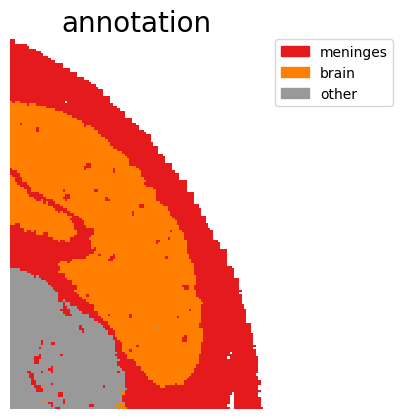

In [6]:
%matplotlib inline

from src.rebosep.plotting import plot_obs_column

plot_obs_column(data, "leiden_annotated")
plt.title("annotation", fontsize=20)
plt.show()

# filter regions by size

There are many small, random clusters that we would like to mask before detecting boundaries. We use `filter_regions` to first calculate region size, and then mask regions below the threshold set with `min_region_size`. This creates a new column in `data.obs`, named `filtered_annotated`.

In [7]:
from src.rebosep.core import filter_regions

data.obs = filter_regions(data.obs,
                          column_to_filter_key="leiden_annotated",        # column with annotation. check data.obs
                          filtered_annotation_key="filtered_annotated",   # column with filtered annotation
                          too_small_label="too_small",                    # label given to regions below size threshold, in the filtered_annotation_key column
                          region_num_key="region_num_key",                # column in data.obs that will contain region id
                          min_region_size=300)                            # minimum region size

filtering regions by size
no region num key column found. If first pass, all good.


## inspect results

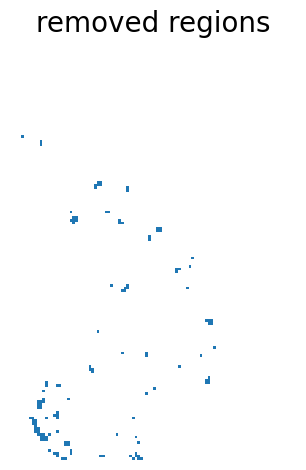

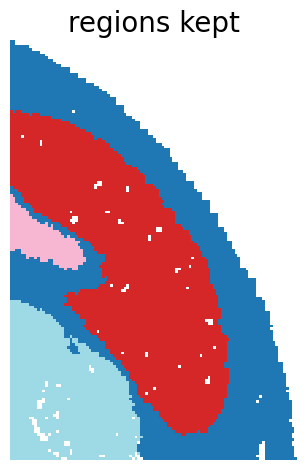

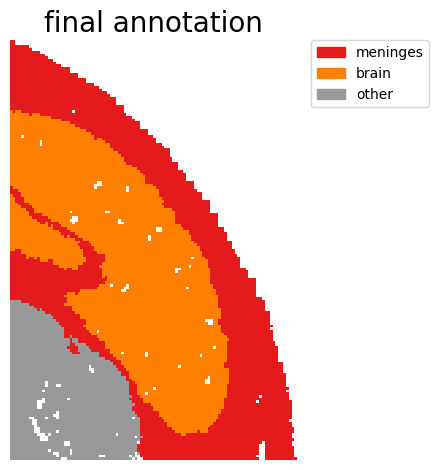

In [8]:
%matplotlib inline

from src.rebosep.plotting import filter_regions_plotting

# plotting the regions that we masked first
filter_regions_plotting(data.obs,
                        region_num_key="region_num_key",
                        plot_masked=True)
plt.axis('off')
plt.title("removed regions", fontsize=20)
plt.tight_layout()
plt.show()


# plotting the regions that will still be used for boundary detection
filter_regions_plotting(data.obs,
                        region_num_key="region_num_key",
                        plot_masked=False)
plt.axis('off')
plt.title("regions kept", fontsize=20)
plt.tight_layout()
plt.show()


# final result
plot_obs_column(data, 
                "filtered_annotated")
plt.title("final annotation", fontsize=20)
plt.tight_layout()
plt.show()

# setting annotation of region manually

In [9]:
# not needed in this case!
# if the annotation of individual regions had to be changed, set_annotation_by_region can be used

# example: this sets bins part of leiden cluster 6 (in the leiden column to ventricle (in the filtered_annotated column)
#data.obs = set_annotation_by_region(data.obs, 
#                                    region=6,                              # region id in region_num_key column
#                                    annotation="ventricle",
#                                    annotation_key="filtered_annotated",
#                                    region_num_key="region_num_key")

# detecting boundaries, and calculating distance from boundaries

In [10]:
from src.rebosep.core import find_boundary_distances

data.obs = find_boundary_distances(data.obs, 
                                   ["brain", "meninges"],                            # regions between which boundaries are detected
                                   clusters_key="filtered_annotated",                # column used to detect boundaries
                                   is_boundary_key_prefix="is_boundary_",            # prefix for boolean column
                                   boundary_dist_key_prefix="boundary_dist_",        # prefix for distance column, first and second clusters will be appended ("boundary_dist_brain_meninges")
                                   min_boundary_length = 400,                        # boundaries shorter than this threshold are ignored
                                   boundary_range = 0,                               # gap in boundaries 
                                   max_dist = 20,                                    # max distance from the boundary detected (in bins)
                                   verbose=True,
                                   print_modulo=5)

detecting boundaries between brain and meninges
no boundary column found. If first pass, all good
running boundary recursion
running distance detection
calculating bins with boundary distance: 20
calculating bins with boundary distance: 15
calculating bins with boundary distance: 10
calculating bins with boundary distance: 5


In [11]:
data.obs

,total_counts,n_genes_by_counts,pct_counts_mt,leiden,leiden_annotated,orig.ident,x,y,region_num_key,filtered_annotated,boundary_dist_brain_meninges
_bin_names,,,,,,,,,,,
0,442,225,3.619910,2,meninges,sample,30120,13740,0.0,meninges,14.0
1,2289,966,0.873744,1,brain,sample,30150,15510,2.0,brain,6.0
2,1484,557,1.280323,1,brain,sample,30270,14190,1.0,brain,1.0
3,2366,957,0.718512,1,brain,sample,30300,14940,1.0,brain,7.0
4,1588,734,0.251889,3,other,sample,30360,17160,3.0,other,NaN
...,...,...,...,...,...,...,...,...,...,...,...
11554,118,73,0.000000,2,meninges,sample,31500,14370,0.0,meninges,13.0
11555,208,119,0.961538,2,meninges,sample,32820,17820,0.0,meninges,19.0
11556,127,84,4.724409,2,meninges,sample,32580,17160,0.0,meninges,6.0


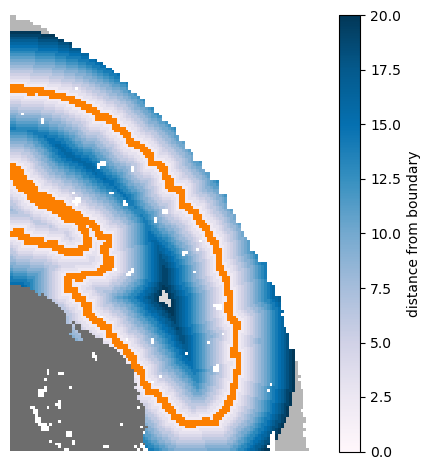

In [12]:
%matplotlib inline

from src.rebosep.plotting import plot_boundary_distances

plot_boundary_distances(data.obs, 
                        boundary_dist_key="boundary_dist_brain_meninges",           # name automatically created during find_boundary_distances, see comments next to parameters
                        verbose=True)
plt.show()

## an excursion: using boundary_range

Some sample might have been damaged during sample handling. In some older StereoSeq data a grid like pattern of bins with very low capture rates is visible. This can disrupt continuous boundaries, and create small fragments. Yet, we would like to filter out short boundaries, for example between small fragments of regions that we could not mask using `filter_regions`.  To allow filtering for long boundaries short interruptions, the boundary_range parameter can be used. Let's first add some "damage" to the sample.

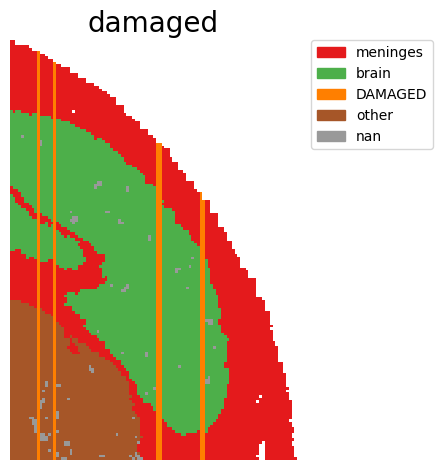

In [13]:
import copy

damaged_data = copy.deepcopy(data)
damaged_data.obs["filtered_annotated"] = damaged_data.obs["filtered_annotated"] .astype('str')  # in case column is categorical


damaged_data.obs.loc[damaged_data.obs['x'] == 30300, 'filtered_annotated'] = "DAMAGED"
damaged_data.obs.loc[damaged_data.obs['x'] == 30480, 'filtered_annotated'] = "DAMAGED"
damaged_data.obs.loc[damaged_data.obs['x'] == 31620, 'filtered_annotated'] = "DAMAGED"
damaged_data.obs.loc[damaged_data.obs['x'] == 31650, 'filtered_annotated'] = "DAMAGED"
damaged_data.obs.loc[damaged_data.obs['x'] == 32100, 'filtered_annotated'] = "DAMAGED"
damaged_data.obs.loc[damaged_data.obs['x'] == 32130, 'filtered_annotated'] = "DAMAGED"

plot_obs_column(damaged_data, 
                "filtered_annotated")
plt.title("damaged", fontsize=20)
plt.tight_layout()
plt.show()

With boundary_range = 0, no gaps are ignored. The function filters out all of the small cluster fragments, as it doesnt recognize the individual fragments as part of a longer boundary.

detecting boundaries between brain and meninges
deleted previous boundary result!
running boundary recursion
running distance detection
calculating bins with boundary distance: 10
calculating bins with boundary distance: 5


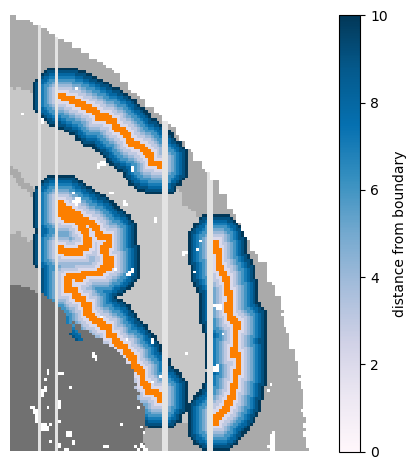

In [14]:
damaged_data.obs = find_boundary_distances(damaged_data.obs, 
                                           ["brain", "meninges"],                            
                                           clusters_key="filtered_annotated",                
                                           is_boundary_key_prefix="is_boundary_",            
                                           boundary_dist_key_prefix="boundary_dist_",        
                                           min_boundary_length = 120,                        
                                           boundary_range = 0,                               
                                           max_dist = 10,
                                           verbose=True,
                                           print_modulo=5)

plt.close("all")
plot_boundary_distances(damaged_data.obs, 
                        boundary_dist_key="boundary_dist_brain_meninges", 
                        verbose=True)
plt.show()

Let's set boundary_range to 4, to detect the whole boundary 

detecting boundaries between brain and meninges
deleted previous boundary result!
running boundary recursion
running distance detection
calculating bins with boundary distance: 10
calculating bins with boundary distance: 5


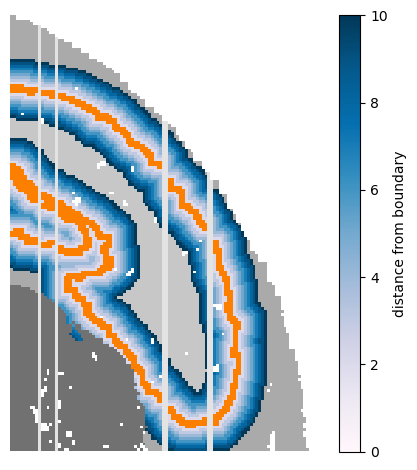

In [15]:
damaged_data.obs = find_boundary_distances(damaged_data.obs, 
                                           ["brain", "meninges"],                            
                                           clusters_key="filtered_annotated",                
                                           is_boundary_key_prefix="is_boundary_",            
                                           boundary_dist_key_prefix="boundary_dist_",        
                                           min_boundary_length = 150,                        
                                           boundary_range = 4,                               
                                           max_dist = 10,
                                           verbose=True,
                                           print_modulo=5)

plt.close("all")
plot_boundary_distances(damaged_data.obs, 
                        boundary_dist_key="boundary_dist_brain_meninges", 
                        verbose=True)
plt.show()

Now, the whole boundary is recognized, despite short interruptions. Short, isolated boundaries are still ignored, thanks to the min_boundary_length parameter.

## manually select region

We are only interested in the outer brain boundary with the meninges. We can select this specific region with select_region_of_interest. We simply draw a shape around the boundary we are interested in.

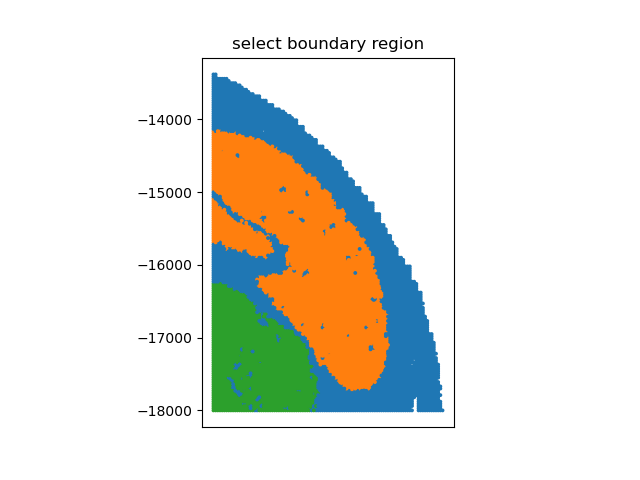

In [22]:
%matplotlib widget

from src.rebosep.core import select_region_of_interest

selection = select_region_of_interest(data, 
                                     set_nan_to_zero=False, 
                                     s=3,                               # markersize
                                     col_name="filtered_annotated",
                                     alpha_background=0.3,
                                     lasso_color="red",
                                     lasso_linewidth=2)

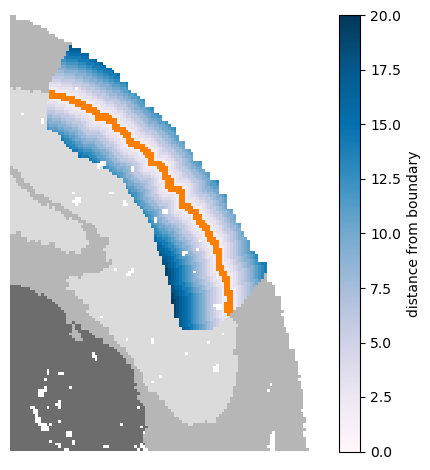

In [50]:
%matplotlib inline

from src.rebosep.helpers import set_manually_selected_region
from src.rebosep.core import create_dist_gene_table

rel_clusters = ["brain", "meninges"]
boundary_dist_key = "boundary_dist_brain_meninges"
selection_name = "dorpal_men"


data.obs = set_manually_selected_region(data.obs, 
                                    selection, 
                                    col_name=selection_name)


plot_boundary_distances(data.obs, 
                        boundary_dist_key=boundary_dist_key, 
                        verbose=True, 
                        manual_selection_key=selection_name,
                        highlight_boundary=True)
plt.show()

dist_gene_df = create_dist_gene_table(data,
                                      rel_clusters,
                                      raw_counts_layer="raw_counts", 
                                      boundary_dist_key=boundary_dist_key, 
                                      filepath=f"{analysis_dir}{sample_name}_tutorial.tsv",
                                      filtered_clusters_key="filtered_annotated",
                                      masking_key=selection_name,
                                      normalization_target_sum=1e4)

To check if our boundary detection and region selection worked, we can plot some genes that we expect to have a striking expression pattern. First we need to check the bin counts to limit the plotting to regions with high coverage.

In [51]:
bin_counts = data.obs[["filtered_annotated", "boundary_dist_brain_meninges", "dorpal_men"]]
bin_counts= bin_counts.loc[bin_counts['dorpal_men']==True]
bin_counts.groupby(['filtered_annotated', 'boundary_dist_brain_meninges']).size().unstack(fill_value=0)

boundary_dist_brain_meninges,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
filtered_annotated,,,,,,,,,,,,,,,,,,,,
brain,147,142,137,97,96,133,89,108,110,92,95,76,68,58,35,33,31,25,12,2
meninges,147,144,145,103,100,147,95,120,121,103,86,52,37,33,18,9,4,1,0,0
other,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We see that the number of bins drops off at 11 bins in both tissue. (Depending on how we selected the region using select_region_of_interest this might be different of course). We will therefor remove distances > 11 from plotting.

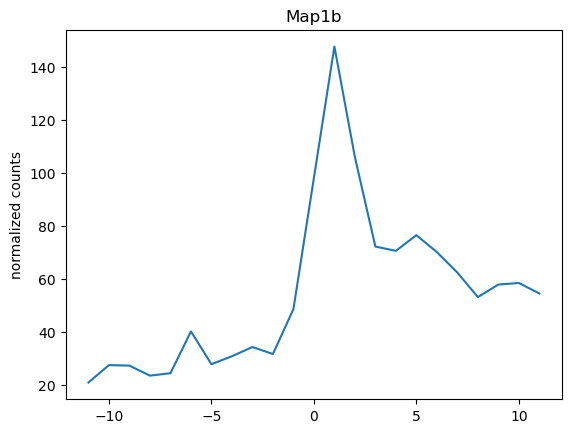

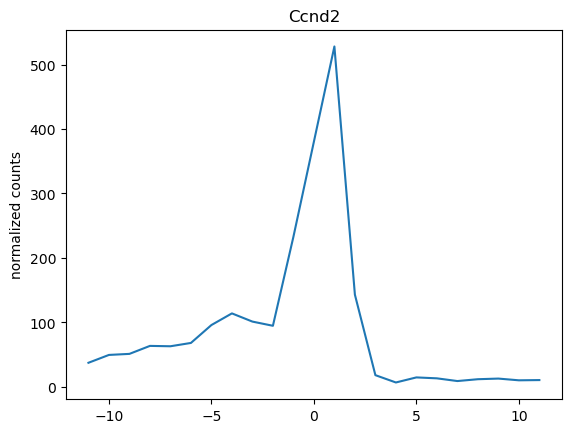

In [64]:
%matplotlib inline

for gene in ["Map1b", "Ccnd2"]:
    plt.plot(dist_gene_df[[gene]].loc[-11:11].index, dist_gene_df[[gene]].loc[-11:11].values)
    
    plt.title(gene)
    plt.ylabel("normalized counts")
    plt.xlabel("distance from boundary (bins)")
    plt.show()